In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [0]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import minmax_scale
import gc

import lightgbm as lgb

import datetime

In [0]:
%cd My\ Drive/gci_competition

/gdrive/My Drive/gci_competition


In [0]:
X_train = pd.read_csv('X_train_without_numGroups1.csv')
Y_train = pd.read_csv('Y_train_without_numGroups1.csv')
X_test = pd.read_csv('X_test.csv')

In [0]:
print(X_train.shape, X_test.shape, Y_train.shape)

(356007, 222) (89019, 222) (356007, 1)


In [0]:
param={'learning_rate': 0.1,
        'objective':'mae',
        'num_leaves': 31,
        'random_state':42,
        'bagging_fraction': 0.03,
        'feature_fraction': 0.85
       }

In [0]:
reg = lgb.LGBMRegressor(**param, n_estimators=1000)

reg.fit(X_train, Y_train)
pred = reg.predict(X_test, num_iteration=reg.best_iteration_)

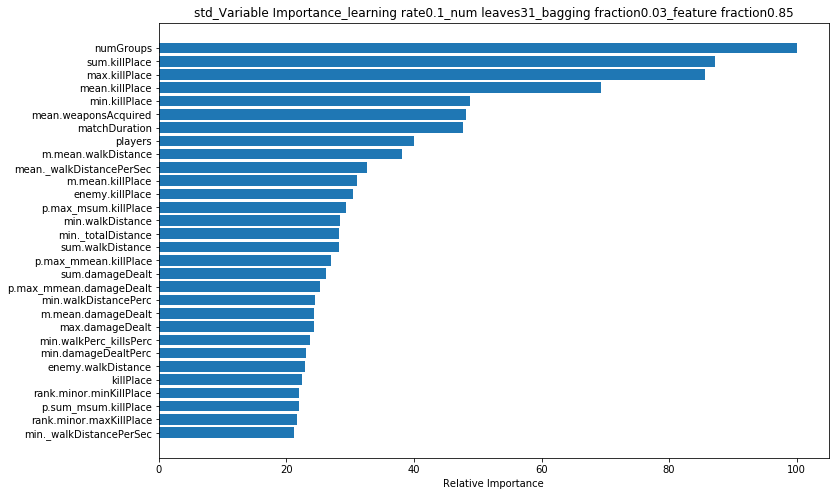

In [0]:
# Plot feature importance
feature_importance = reg.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[len(feature_importance) - 30:]
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12,8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('std_Variable Importance_learning rate'+ str(param["learning_rate"]) + '_num leaves' + str(param["num_leaves"]) + '_bagging fraction' + str(param["bagging_fraction"]) + '_feature fraction' + str(param["feature_fraction"]))

dt_now = datetime.datetime.now()
dt = dt_now.strftime('%m%d%H%M')

plt.savefig(dt+'feature_engineering.png')
plt.show()

In [0]:
X_train_100 = X_train[X_train.columns[np.argsort(-feature_importance)][:100]]
X_test_100 = X_test[X_train.columns[np.argsort(-feature_importance)][:100]]
X_train_80 = X_train[X_train.columns[np.argsort(-feature_importance)][:80]]
X_test_80 = X_test[X_train.columns[np.argsort(-feature_importance)][:80]]

In [0]:
#X_train_100.to_csv("X_train_without_numGroups1_31_100.csv", index=False)
#X_test_100.to_csv("X_test_without_numGroups1_31_100.csv", index=False)
X_train_80.to_csv("X_train_without_numGroups1_31_80.csv", index=False)
X_test_80.to_csv("X_test_without_numGroups1_31_80.csv", index=False)

In [0]:
ans = pd.DataFrame(pred, columns=["winPlacePerc"])

In [0]:
ans_norm = minmax_scale(ans)
ans_norm = pd.DataFrame(ans_norm, columns=["winPlacePerc"])

In [0]:
ans_norm.describe()

,winPlacePerc
count,89019.000000
mean,0.479354
std,0.261244
min,0.000000
25%,0.246848
50%,0.465818
75%,0.715231
max,1.000000


In [0]:
test = pd.concat([X_test, ans_norm], axis=1)

idx = test[test.numGroups ==1].index
test.loc[list(idx), ["winPlacePerc"]] = 0

ans_norm = test[["winPlacePerc"]]

In [0]:
dt_now = datetime.datetime.now()
dt = dt_now.strftime('%m%d%H%M')

#ans_norm.to_csv(dt+"competition_without_numGroups1_31.csv", index=False)